# Imports

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
!pip install torchinfo
from torchinfo import summary

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
tform = transforms.Compose([
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 0.2)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=(0, 180))
        ])

In [4]:
df = pd.DataFrame({'img': os.listdir("UTKface_Aligned_cropped/UTKFace/")})
df['age'] = df['img'].str.split('_').str[0]
df['gender'] = df['img'].str.split('_').str[1]
df['ethnicity'] = df['img'].str.split('_').str[2]
df['age'] = df['age'].astype(float) # changed to float to deal with pd.cut comparing with np.inf later

# create bins
n_buckets = 12
labels = [i for i in range(12)]
bins = [i*10 for i in range(12)] + [np.inf]

# pd.cut each column, with each bin closed on left and open on right
# train_data.csv['age'].apply(lambda x: pd.cut(x, bins=bins, labels=labels, include_lowest=True))
# [1, 2, 3, 4] => [1,2], (2,3], (3,4]

df['age_bucket'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

# generate label dictionary
first = {0: '0-10'}
mid = {i: f'{i*10+1}-{i*10+10}' for i in range(1, 11)}
last = {11: '110+'}

labels_dict = first
labels_dict.update(mid)
labels_dict.update(last)
labels_dict

# export
df.to_csv('img_csv', index=False);
df

img   age gender ethnicity age_bucket
0       9_1_2_20161219204347420.jpg.chip.jpg   9.0      1         2          0
1      36_0_1_20170117163203851.jpg.chip.jpg  36.0      0         1          3
2      86_1_0_20170120225751953.jpg.chip.jpg  86.0      1         0          8
3      26_1_0_20170116171048641.jpg.chip.jpg  26.0      1         0          2
4       1_1_2_20161219154612988.jpg.chip.jpg   1.0      1         2          0
...                                      ...   ...    ...       ...        ...
23703  35_0_0_20170117155112202.jpg.chip.jpg  35.0      0         0          3
23704  52_0_3_20170119200211340.jpg.chip.jpg  52.0      0         3          5
23705  26_0_1_20170116010114628.jpg.chip.jpg  26.0      0         1          2
23706  28_0_1_20170117015458481.jpg.chip.jpg  28.0      0         1          2
23707  50_1_1_20170120220813715.jpg.chip.jpg  50.0      1         1          4

[23708 rows x 5 columns]

In [5]:
BATCH_SIZE = 64
EPOCHS = 25
IMG_SIZE = 256

In [6]:
class AgeDataset(torch.utils.data.Dataset):
    """
    Dataset that contains:
        csv files with image_id and image_label
        real image directory
    """

    def __init__(self, image_dir='UTKface_Aligned_cropped/UTKFace/',
                 train=False):
        self.csv = pd.read_csv('img_csv')
        self.image_dir = image_dir
        self.train = train

    def __getitem__(self, index):
        img_id, img_age_label, img_gender_label, img_ethnicity_label, img_age_bucket_label = self.csv.iloc[index]

        # get the images and transform to tensor
        image  = Image.open(self.image_dir + img_id)
        image_tensor = transforms.ToTensor()(image)
        image_tensor = transforms.Resize((IMG_SIZE, IMG_SIZE))(image_tensor)

        # normalize
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        image_tensor = normalize(image_tensor)

        # transformations
        if (self.train):
            image_tensor = tform(image_tensor)
        
        # convert labels to torch LongTensors. from_numpy expects an array
        img_age_bucket_label = torch.from_numpy(np.asarray(img_age_bucket_label)).long()
        
        return image_tensor, img_age_bucket_label # only returns age right now
    
    def __len__(self):
        return len(self.csv)

In [7]:
# for reverting normalization for visualization purposes
invTrans = transforms.Normalize(
                mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
train_data = AgeDataset(train=True)
val_data = AgeDataset()

indices = list(range(len(train_data)))
np.random.shuffle(indices)
train_size = int(0.8 * len(train_data))
train_idx, val_idx = indices[:train_size], indices[train_size:]

train_dataset = torch.utils.data.SubsetRandomSampler(train_idx)
val_dataset = torch.utils.data.SubsetRandomSampler(val_idx)

In [49]:
n_classes = train_data.csv['age'].max() + 1 # largest age is 116, smallest 1 in data. but we will include 0
# as an option, so 117 classes

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_dataset)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, sampler=val_dataset)

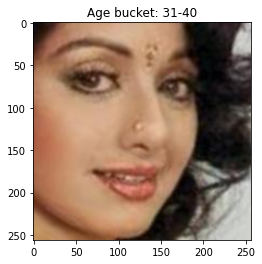

In [11]:
batch_images, batch_labels = next(iter(val_loader))
plt.imshow(invTrans(batch_images[0]).permute(1,2,0))

plt.title(f"Age bucket: {labels_dict[int(batch_labels[0])]}")
plt.show()

# Modelling

In [12]:
class AgeClassifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, bias=False)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5, bias=False)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=5, bias=False)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(24)
        self.conv4 = nn.Conv2d(24, 24, kernel_size=5)
        self.pool4 = nn.MaxPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(13824, n_buckets)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bn1(self.pool1(self.relu(self.conv1(x))))
        x = self.bn2(self.pool2(self.relu(self.conv2(x))))
        x = self.bn3(self.pool3(self.relu(self.conv3(x))))
        x = self.pool4(self.relu(self.conv4(x)))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [13]:
model = AgeClassifier()

In [14]:
# testing input and output sizes of model
summary(model, (64, 3, 256, 256)) # model will expect a batch of 64 images, each of shape 3 x 256 x 256

Layer (type:depth-idx)                   Output Shape              Param #
AgeClassifier                            --                        --
├─Conv2d: 1-1                            [64, 6, 252, 252]         450
├─ReLU: 1-2                              [64, 6, 252, 252]         --
├─MaxPool2d: 1-3                         [64, 6, 126, 126]         --
├─BatchNorm2d: 1-4                       [64, 6, 126, 126]         12
├─Conv2d: 1-5                            [64, 12, 122, 122]        1,800
├─ReLU: 1-6                              [64, 12, 122, 122]        --
├─MaxPool2d: 1-7                         [64, 12, 61, 61]          --
├─BatchNorm2d: 1-8                       [64, 12, 61, 61]          24
├─Conv2d: 1-9                            [64, 24, 57, 57]          7,200
├─ReLU: 1-10                             [64, 24, 57, 57]          --
├─MaxPool2d: 1-11                        [64, 24, 28, 28]          --
├─BatchNorm2d: 1-12                      [64, 24, 28, 28]          48
├─Conv2d

# Training

In [44]:
optimizer = optim.AdamW(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# additional RMSE loss to incorporate ordinality of buckets
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

rmse = RMSELoss()

##### note: if you do ever run the model again and checkpoint it, and want to load in to continue training, run the cell below this one first.

In [50]:
model = model.to(device)

step = 0
losses = []
accuracies = []
start_epoch = 0
for epoch in range(start_epoch, EPOCHS):
    print(f"Epoch {epoch + 1} of {EPOCHS}")

    # Loop over each batch in the dataset
    for batch in tqdm(train_loader):
        
        model.train()
        
        # Backpropagation and gradient descent
        images, labels = batch

        # Move to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the gradient
        optimizer.zero_grad()
        # we could also move this to the end,
        # as long as we don't do it between the loss.backward()
        # and optimizer.step() operation which would discard the gradient info needed to make a step
        
        # Forward propagation
        outputs = model(images)

        # Backward propagation
        # our RMSE function requires equal dimensions so we extract our model predictions before inputting
        loss = loss_fn(outputs, labels) + rmse(outputs.argmax(axis=1).float(), labels)
        loss.backward()
        optimizer.step()
        step += 1

        # append + print training loss every 25 batches
        if step % 20 == 0:
            losses.append(loss.item())
            print(f"Loss: {loss.item():.5f}")
        
        # also, evaluate accuracy every 100 batches
        if step % 100 == 0:
            # Set model to evaluate mode.
            # This notifies all your layers that you are in eval mode, so that batchnorm and dropout layers
            # will work in eval mode instead of training mode
            model.eval()

            model = model.to(device)

            correct_num = 0
            total_num = 0
            
            with torch.no_grad(): 
            # torch.no_grad() deactivates autograd, reducing memory usage and speeding up computations
            # but you won’t be able to backprop
                for batch in val_loader:
                    images, labels = batch

                    images = images.to(device)
                    labels = labels.to(device)
                    
                    predictions = model(images).argmax(axis=1)
                    correct_num += (predictions == labels).sum().item()
                    total_num += len(labels)
            
                accuracy = correct_num / total_num
                accuracies.append(accuracy)
                print(f"Validation Accuracy: {100*accuracy:.5f}%")
    
    torch.save(
            {
                "epoch": epoch,
                "loss": loss.item(),
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f'DSUAgeBucketModel_epoch_{epoch+1}.pt'
        )
    
    with open("losses.json", 'w') as f1:
        json.dump(losses, f1) 

    with open("accuracies.json", 'w') as f2:
        json.dump(accuracies, f2)
    
    print('Epoch: ', epoch + 1, 'Loss: ', loss.item())

Epoch 1 of 25


  7%|██▊                                       | 20/297 [00:59<14:08,  3.06s/it]

Loss: 4.10867


 13%|█████▋                                    | 40/297 [01:58<12:40,  2.96s/it]

Loss: 3.49200


 20%|████████▍                                 | 60/297 [03:02<13:32,  3.43s/it]

Loss: 3.26753


 27%|███████████▎                              | 80/297 [04:07<11:41,  3.23s/it]

Loss: 3.79321


 33%|██████████████                            | 99/297 [05:06<09:13,  2.79s/it]

Loss: 3.88175


 34%|█████████████▏                         | 100/297 [06:30<1:28:41, 27.01s/it]

Validation Accuracy: 30.05061%


 40%|████████████████▌                        | 120/297 [07:30<08:30,  2.88s/it]

Loss: 4.04740


 47%|███████████████████▎                     | 140/297 [08:33<08:25,  3.22s/it]

Loss: 3.68182


 54%|██████████████████████                   | 160/297 [09:39<08:07,  3.56s/it]

Loss: 3.60036


 61%|████████████████████████▊                | 180/297 [10:46<06:48,  3.49s/it]

Loss: 3.34318


 67%|███████████████████████████▍             | 199/297 [11:51<05:14,  3.21s/it]

Loss: 3.90891


 67%|███████████████████████████▌             | 200/297 [13:09<41:29, 25.66s/it]

Validation Accuracy: 36.46141%


 74%|██████████████████████████████▎          | 220/297 [14:09<03:55,  3.06s/it]

Loss: 2.91129


 81%|█████████████████████████████████▏       | 240/297 [15:10<02:57,  3.12s/it]

Loss: 3.11024


 88%|███████████████████████████████████▉     | 260/297 [16:07<01:45,  2.86s/it]

Loss: 3.05332


 94%|██████████████████████████████████████▋  | 280/297 [17:07<00:48,  2.85s/it]

Loss: 3.58474


100%|█████████████████████████████████████████| 297/297 [17:54<00:00,  3.62s/it]


Epoch:  1 Loss:  3.003164291381836
Epoch 2 of 25


  1%|▎                                          | 2/297 [00:05<13:45,  2.80s/it]

Loss: 3.92786


  1%|▍                                        | 3/297 [01:21<2:57:30, 36.23s/it]

Validation Accuracy: 42.00759%


  8%|███▎                                      | 23/297 [02:21<13:24,  2.94s/it]

Loss: 3.56868


 14%|██████                                    | 43/297 [03:22<12:45,  3.01s/it]

Loss: 3.26314


 21%|████████▉                                 | 63/297 [04:23<11:57,  3.07s/it]

Loss: 3.77874


 28%|███████████▋                              | 83/297 [05:20<10:10,  2.85s/it]

Loss: 3.14794


 34%|██████████████                           | 102/297 [06:16<09:29,  2.92s/it]

Loss: 3.41263


 35%|█████████████▌                         | 103/297 [07:31<1:19:03, 24.45s/it]

Validation Accuracy: 41.96542%


 41%|████████████████▉                        | 123/297 [08:32<09:35,  3.31s/it]

Loss: 3.28895


 48%|███████████████████▋                     | 143/297 [09:26<07:06,  2.77s/it]

Loss: 3.64574


 55%|██████████████████████▌                  | 163/297 [10:26<06:13,  2.79s/it]

Loss: 3.29294


 62%|█████████████████████████▎               | 183/297 [11:28<05:57,  3.14s/it]

Loss: 3.16564


 68%|███████████████████████████▉             | 202/297 [12:26<04:48,  3.04s/it]

Loss: 3.70110


 68%|████████████████████████████             | 203/297 [13:41<38:50, 24.79s/it]

Validation Accuracy: 42.64024%


 75%|██████████████████████████████▊          | 223/297 [14:42<03:50,  3.12s/it]

Loss: 3.07594


 82%|█████████████████████████████████▌       | 243/297 [15:42<02:44,  3.06s/it]

Loss: 2.68882


 89%|████████████████████████████████████▎    | 263/297 [16:41<01:37,  2.86s/it]

Loss: 3.18381


 95%|███████████████████████████████████████  | 283/297 [17:45<00:44,  3.16s/it]

Loss: 3.61868


100%|█████████████████████████████████████████| 297/297 [18:26<00:00,  3.72s/it]


Epoch:  2 Loss:  3.1998631954193115
Epoch 3 of 25


  2%|▋                                          | 5/297 [00:15<14:48,  3.04s/it]

Loss: 3.28556


  2%|▊                                        | 6/297 [01:29<2:11:25, 27.10s/it]

Validation Accuracy: 42.30283%


  9%|███▋                                      | 26/297 [02:27<13:10,  2.92s/it]

Loss: 3.46894


 15%|██████▌                                   | 46/297 [03:24<11:46,  2.82s/it]

Loss: 3.33622


 22%|█████████▎                                | 66/297 [04:21<10:49,  2.81s/it]

Loss: 2.81319


 29%|████████████▏                             | 86/297 [05:20<10:42,  3.04s/it]

Loss: 3.24246


 35%|██████████████▍                          | 105/297 [06:16<09:04,  2.83s/it]

Loss: 2.83840


 36%|█████████████▉                         | 106/297 [07:28<1:14:43, 23.48s/it]

Validation Accuracy: 43.37832%


 42%|█████████████████▍                       | 126/297 [08:28<10:18,  3.62s/it]

Loss: 3.05741


 49%|████████████████████▏                    | 146/297 [09:30<08:06,  3.22s/it]

Loss: 2.89934


 56%|██████████████████████▉                  | 166/297 [10:28<06:08,  2.82s/it]

Loss: 2.24267


 63%|█████████████████████████▋               | 186/297 [11:27<05:06,  2.76s/it]

Loss: 3.25622


 69%|████████████████████████████▎            | 205/297 [12:21<04:22,  2.85s/it]

Loss: 2.93554


 69%|████████████████████████████▍            | 206/297 [13:32<35:22, 23.32s/it]

Validation Accuracy: 44.77014%


 76%|███████████████████████████████▏         | 226/297 [14:31<03:27,  2.92s/it]

Loss: 2.85117


 83%|█████████████████████████████████▉       | 246/297 [15:31<02:29,  2.93s/it]

Loss: 3.04013


 90%|████████████████████████████████████▋    | 266/297 [16:29<01:34,  3.04s/it]

Loss: 3.10052


 96%|███████████████████████████████████████▍ | 286/297 [17:30<00:32,  2.97s/it]

Loss: 3.69727


100%|█████████████████████████████████████████| 297/297 [18:02<00:00,  3.64s/it]


Epoch:  3 Loss:  3.9017252922058105
Epoch 4 of 25


  3%|█▏                                         | 8/297 [00:24<15:31,  3.22s/it]

Loss: 3.19663


  3%|█▏                                       | 9/297 [01:53<2:24:27, 30.10s/it]

Validation Accuracy: 43.08309%


 10%|████                                      | 29/297 [02:54<13:49,  3.09s/it]

Loss: 2.64677


 16%|██████▉                                   | 49/297 [03:53<13:34,  3.28s/it]

Loss: 2.83802


 23%|█████████▊                                | 69/297 [04:54<11:39,  3.07s/it]

Loss: 2.99146


 30%|████████████▌                             | 89/297 [05:57<11:03,  3.19s/it]

Loss: 2.83122


 36%|██████████████▉                          | 108/297 [06:54<09:36,  3.05s/it]

Loss: 3.00723


 37%|██████████████▎                        | 109/297 [08:13<1:20:41, 25.75s/it]

Validation Accuracy: 45.14973%


 43%|█████████████████▊                       | 129/297 [09:11<07:54,  2.82s/it]

Loss: 2.96961


 50%|████████████████████▌                    | 149/297 [10:08<07:06,  2.88s/it]

Loss: 2.95181


 57%|███████████████████████▎                 | 169/297 [11:06<06:23,  3.00s/it]

Loss: 2.87614


 64%|██████████████████████████               | 189/297 [12:04<05:03,  2.81s/it]

Loss: 2.73468


 70%|████████████████████████████▋            | 208/297 [13:00<04:27,  3.01s/it]

Loss: 3.00056


 70%|████████████████████████████▊            | 209/297 [14:20<38:18, 26.12s/it]

Validation Accuracy: 45.86672%


 77%|███████████████████████████████▌         | 229/297 [15:17<03:09,  2.79s/it]

Loss: 3.16947


 84%|██████████████████████████████████▎      | 249/297 [16:15<02:16,  2.85s/it]

Loss: 3.36912


 91%|█████████████████████████████████████▏   | 269/297 [17:11<01:19,  2.82s/it]

Loss: 2.53821


 97%|███████████████████████████████████████▉ | 289/297 [18:12<00:23,  2.97s/it]

Loss: 2.62859


100%|█████████████████████████████████████████| 297/297 [18:33<00:00,  3.75s/it]


Epoch:  4 Loss:  3.5108590126037598
Epoch 5 of 25


  4%|█▌                                        | 11/297 [00:32<13:24,  2.81s/it]

Loss: 2.79852


  4%|█▌                                      | 12/297 [01:43<1:51:50, 23.55s/it]

Validation Accuracy: 45.25517%


 11%|████▌                                     | 32/297 [02:39<12:17,  2.78s/it]

Loss: 3.27380


 18%|███████▎                                  | 52/297 [03:35<11:15,  2.76s/it]

Loss: 2.80200


 24%|██████████▏                               | 72/297 [04:34<11:16,  3.01s/it]

Loss: 2.52066


 31%|█████████████                             | 92/297 [05:39<11:07,  3.26s/it]

Loss: 2.65905


 37%|███████████████▎                         | 111/297 [06:34<09:08,  2.95s/it]

Loss: 2.73429


 38%|██████████████▋                        | 112/297 [07:52<1:18:10, 25.35s/it]

Validation Accuracy: 46.37284%


 44%|██████████████████▏                      | 132/297 [08:52<07:56,  2.89s/it]

Loss: 3.14697


 51%|████████████████████▉                    | 152/297 [09:54<08:01,  3.32s/it]

Loss: 2.83906


 58%|███████████████████████▋                 | 172/297 [10:54<06:12,  2.98s/it]

Loss: 2.99191


 65%|██████████████████████████▌              | 192/297 [11:58<05:18,  3.03s/it]

Loss: 2.65122


 71%|█████████████████████████████▏           | 211/297 [12:56<04:14,  2.96s/it]

Loss: 2.30089


 71%|█████████████████████████████▎           | 212/297 [14:10<34:28, 24.33s/it]

Validation Accuracy: 46.30957%


 78%|████████████████████████████████         | 232/297 [15:10<03:18,  3.05s/it]

Loss: 2.76801


 85%|██████████████████████████████████▊      | 252/297 [16:08<02:12,  2.95s/it]

Loss: 3.25367


 92%|█████████████████████████████████████▌   | 272/297 [17:07<01:16,  3.05s/it]

Loss: 3.32090


 98%|████████████████████████████████████████▎| 292/297 [18:08<00:15,  3.17s/it]

Loss: 2.96152


100%|█████████████████████████████████████████| 297/297 [18:22<00:00,  3.71s/it]


Epoch:  5 Loss:  2.5350098609924316
Epoch 6 of 25


  5%|█▉                                        | 14/297 [00:43<15:16,  3.24s/it]

Loss: 2.30716


  5%|██                                      | 15/297 [02:01<2:02:19, 26.03s/it]

Validation Accuracy: 45.76128%


 12%|████▉                                     | 35/297 [03:04<13:33,  3.11s/it]

Loss: 3.77290


 19%|███████▊                                  | 55/297 [04:03<11:16,  2.80s/it]

Loss: 2.97651


 25%|██████████▌                               | 75/297 [05:03<10:55,  2.95s/it]

Loss: 2.26830


 32%|█████████████▍                            | 95/297 [06:03<09:59,  2.97s/it]

Loss: 3.11146


 38%|███████████████▋                         | 114/297 [07:01<08:59,  2.95s/it]

Loss: 2.69250


 39%|███████████████                        | 115/297 [08:21<1:19:27, 26.20s/it]

Validation Accuracy: 46.39393%


 45%|██████████████████▋                      | 135/297 [09:19<07:47,  2.89s/it]

Loss: 2.37386


 52%|█████████████████████▍                   | 155/297 [10:20<07:23,  3.12s/it]

Loss: 2.89841


 59%|████████████████████████▏                | 175/297 [11:23<06:10,  3.03s/it]

Loss: 3.15302


 66%|██████████████████████████▉              | 195/297 [12:17<04:40,  2.75s/it]

Loss: 2.86012


 72%|█████████████████████████████▌           | 214/297 [13:09<03:44,  2.70s/it]

Loss: 2.63077


 72%|█████████████████████████████▋           | 215/297 [14:21<31:58, 23.40s/it]

Validation Accuracy: 46.98439%


 79%|████████████████████████████████▍        | 235/297 [15:16<02:53,  2.80s/it]

Loss: 2.33559


 86%|███████████████████████████████████▏     | 255/297 [16:11<01:53,  2.69s/it]

Loss: 2.85276


 93%|█████████████████████████████████████▉   | 275/297 [17:04<00:59,  2.72s/it]

Loss: 2.42248


 99%|████████████████████████████████████████▋| 295/297 [17:59<00:05,  2.87s/it]

Loss: 2.48365


100%|█████████████████████████████████████████| 297/297 [18:03<00:00,  3.65s/it]


Epoch:  6 Loss:  3.34443998336792
Epoch 7 of 25


  6%|██▍                                       | 17/297 [00:48<12:42,  2.72s/it]

Loss: 2.68508


  6%|██▍                                     | 18/297 [01:58<1:45:39, 22.72s/it]

Validation Accuracy: 46.81569%


 13%|█████▎                                    | 38/297 [02:53<11:59,  2.78s/it]

Loss: 2.87821


 20%|████████▏                                 | 58/297 [03:47<10:51,  2.72s/it]

Loss: 2.87612


 26%|███████████                               | 78/297 [04:46<10:49,  2.97s/it]

Loss: 2.77503


 33%|█████████████▊                            | 98/297 [05:43<09:23,  2.83s/it]

Loss: 3.11723


 39%|████████████████▏                        | 117/297 [06:40<08:56,  2.98s/it]

Loss: 2.53050


 40%|███████████████▍                       | 118/297 [07:54<1:12:24, 24.27s/it]

Validation Accuracy: 44.62252%


 46%|███████████████████                      | 138/297 [08:49<07:22,  2.78s/it]

Loss: 2.59809


 53%|█████████████████████▊                   | 158/297 [09:45<06:27,  2.79s/it]

Loss: 2.51876


 60%|████████████████████████▌                | 178/297 [10:39<05:27,  2.75s/it]

Loss: 3.38325


 67%|███████████████████████████▎             | 198/297 [11:34<04:27,  2.70s/it]

Loss: 3.26929


 73%|█████████████████████████████▉           | 217/297 [12:26<03:41,  2.76s/it]

Loss: 2.32741


 73%|██████████████████████████████           | 218/297 [13:36<30:10, 22.92s/it]

Validation Accuracy: 45.63475%


 80%|████████████████████████████████▊        | 238/297 [14:32<02:43,  2.77s/it]

Loss: 2.55307


 87%|███████████████████████████████████▌     | 258/297 [15:29<01:50,  2.84s/it]

Loss: 2.93264


 94%|██████████████████████████████████████▍  | 278/297 [16:24<00:53,  2.83s/it]

Loss: 3.07071


100%|█████████████████████████████████████████| 297/297 [17:16<00:00,  3.49s/it]


Epoch:  7 Loss:  2.9325289726257324
Epoch 8 of 25


  0%|▏                                          | 1/297 [00:03<18:18,  3.71s/it]

Loss: 2.38434


  7%|██▊                                       | 20/297 [01:00<13:06,  2.84s/it]

Loss: 2.29774


  7%|██▊                                     | 21/297 [02:11<1:47:20, 23.34s/it]

Validation Accuracy: 46.07760%


 14%|█████▊                                    | 41/297 [03:06<11:48,  2.77s/it]

Loss: 2.56659


 21%|████████▋                                 | 61/297 [04:01<10:59,  2.80s/it]

Loss: 2.68921


 27%|███████████▍                              | 81/297 [04:57<10:03,  2.79s/it]

Loss: 2.72509


 34%|█████████████▉                           | 101/297 [05:58<09:47,  3.00s/it]

Loss: 2.90626


 40%|████████████████▌                        | 120/297 [06:51<08:13,  2.79s/it]

Loss: 3.05244


 41%|███████████████▉                       | 121/297 [08:02<1:08:06, 23.22s/it]

Validation Accuracy: 45.88781%


 47%|███████████████████▍                     | 141/297 [08:59<07:19,  2.82s/it]

Loss: 2.78838


 54%|██████████████████████▏                  | 161/297 [09:54<06:22,  2.82s/it]

Loss: 2.97229


 61%|████████████████████████▉                | 181/297 [10:49<05:21,  2.77s/it]

Loss: 2.46434


 68%|███████████████████████████▋             | 201/297 [11:45<04:19,  2.70s/it]

Loss: 2.75143


 74%|██████████████████████████████▎          | 220/297 [12:37<03:26,  2.69s/it]

Loss: 2.36373


 74%|██████████████████████████████▌          | 221/297 [13:51<30:27, 24.04s/it]

Validation Accuracy: 44.79123%


 81%|█████████████████████████████████▎       | 241/297 [14:44<02:33,  2.73s/it]

Loss: 2.73191


 88%|████████████████████████████████████     | 261/297 [15:40<01:39,  2.76s/it]

Loss: 2.29105


 95%|██████████████████████████████████████▊  | 281/297 [16:34<00:42,  2.68s/it]

Loss: 2.73523


100%|█████████████████████████████████████████| 297/297 [17:16<00:00,  3.49s/it]


Epoch:  8 Loss:  4.001797676086426
Epoch 9 of 25


  1%|▌                                          | 4/297 [00:10<13:14,  2.71s/it]

Loss: 2.56551


  8%|███▎                                      | 23/297 [01:03<12:38,  2.77s/it]

Loss: 3.04911


  8%|███▏                                    | 24/297 [02:15<1:45:57, 23.29s/it]

Validation Accuracy: 46.66807%


 15%|██████▏                                   | 44/297 [03:19<13:16,  3.15s/it]

Loss: 2.71786


 22%|█████████                                 | 64/297 [04:15<10:46,  2.77s/it]

Loss: 2.72799


 28%|███████████▉                              | 84/297 [05:13<10:13,  2.88s/it]

Loss: 2.69923


 35%|██████████████▎                          | 104/297 [06:08<09:00,  2.80s/it]

Loss: 2.62173


 41%|████████████████▉                        | 123/297 [07:02<08:18,  2.87s/it]

Loss: 3.04655


 42%|████████████████▎                      | 124/297 [08:13<1:07:51, 23.54s/it]

Validation Accuracy: 46.98439%


 48%|███████████████████▉                     | 144/297 [09:10<07:16,  2.85s/it]

Loss: 2.61783


 55%|██████████████████████▋                  | 164/297 [10:07<06:12,  2.80s/it]

Loss: 2.39721


 62%|█████████████████████████▍               | 184/297 [11:03<05:27,  2.90s/it]

Loss: 2.65904


 69%|████████████████████████████▏            | 204/297 [12:01<04:32,  2.93s/it]

Loss: 3.02192


 75%|██████████████████████████████▊          | 223/297 [12:57<03:47,  3.07s/it]

Loss: 2.62921


 75%|██████████████████████████████▉          | 224/297 [14:09<28:39, 23.56s/it]

Validation Accuracy: 46.45719%


 82%|█████████████████████████████████▋       | 244/297 [15:04<02:31,  2.85s/it]

Loss: 2.45647


 89%|████████████████████████████████████▍    | 264/297 [16:01<01:31,  2.77s/it]

Loss: 2.69778


 96%|███████████████████████████████████████▏ | 284/297 [16:59<00:38,  2.96s/it]

Loss: 2.81014


100%|█████████████████████████████████████████| 297/297 [17:36<00:00,  3.56s/it]


Epoch:  9 Loss:  1.8558591604232788
Epoch 10 of 25


  2%|█                                          | 7/297 [00:21<14:52,  3.08s/it]

Loss: 2.92023


  9%|███▋                                      | 26/297 [01:19<13:46,  3.05s/it]

Loss: 2.27057


  9%|███▋                                    | 27/297 [02:38<1:56:06, 25.80s/it]

Validation Accuracy: 46.43610%


 16%|██████▋                                   | 47/297 [03:38<11:24,  2.74s/it]

Loss: 3.08175


 23%|█████████▍                                | 67/297 [04:39<11:12,  2.92s/it]

Loss: 2.94674


 29%|████████████▎                             | 87/297 [05:36<09:50,  2.81s/it]

Loss: 2.61959


 36%|██████████████▊                          | 107/297 [06:35<09:17,  2.94s/it]

Loss: 2.82932


 42%|█████████████████▍                       | 126/297 [07:29<08:15,  2.90s/it]

Loss: 2.55735


 43%|████████████████▋                      | 127/297 [08:57<1:20:25, 28.38s/it]

Validation Accuracy: 45.67693%


 49%|████████████████████▎                    | 147/297 [10:04<08:12,  3.29s/it]

Loss: 2.28293


 56%|███████████████████████                  | 167/297 [11:07<06:28,  2.99s/it]

Loss: 2.65161


 63%|█████████████████████████▊               | 187/297 [12:05<05:23,  2.94s/it]

Loss: 2.73241


 70%|████████████████████████████▌            | 207/297 [13:04<04:27,  2.97s/it]

Loss: 2.59786


 76%|███████████████████████████████▏         | 226/297 [13:59<03:24,  2.88s/it]

Loss: 2.54207


 76%|███████████████████████████████▎         | 227/297 [15:14<28:38, 24.55s/it]

Validation Accuracy: 47.70139%


 83%|██████████████████████████████████       | 247/297 [16:12<02:23,  2.87s/it]

Loss: 2.70503


 90%|████████████████████████████████████▊    | 267/297 [17:09<01:21,  2.73s/it]

Loss: 2.92283


 97%|███████████████████████████████████████▌ | 287/297 [18:07<00:28,  2.87s/it]

Loss: 2.92131


100%|█████████████████████████████████████████| 297/297 [18:34<00:00,  3.75s/it]


Epoch:  10 Loss:  3.0308051109313965
Epoch 11 of 25


  3%|█▍                                        | 10/297 [00:27<13:43,  2.87s/it]

Loss: 2.84012


 10%|████                                      | 29/297 [01:24<12:59,  2.91s/it]

Loss: 3.07992


 10%|████                                    | 30/297 [02:39<1:48:46, 24.44s/it]

Validation Accuracy: 47.89119%


 17%|███████                                   | 50/297 [03:37<12:53,  3.13s/it]

Loss: 2.64566


 24%|█████████▉                                | 70/297 [04:35<10:42,  2.83s/it]

Loss: 2.54182


 30%|████████████▋                             | 90/297 [05:35<10:54,  3.16s/it]

Loss: 3.04056


 37%|███████████████▏                         | 110/297 [06:35<09:58,  3.20s/it]

Loss: 2.89043


 43%|█████████████████▊                       | 129/297 [07:30<07:44,  2.76s/it]

Loss: 2.76196


 44%|█████████████████                      | 130/297 [08:38<1:02:38, 22.51s/it]

Validation Accuracy: 45.27625%


 51%|████████████████████▋                    | 150/297 [09:33<06:48,  2.78s/it]

Loss: 2.37317


 57%|███████████████████████▍                 | 170/297 [10:27<05:41,  2.69s/it]

Loss: 2.77442


 64%|██████████████████████████▏              | 190/297 [11:21<04:48,  2.70s/it]

Loss: 2.80315


 71%|████████████████████████████▉            | 210/297 [12:16<03:57,  2.73s/it]

Loss: 2.48857


 77%|███████████████████████████████▌         | 229/297 [13:08<03:07,  2.75s/it]

Loss: 2.70746


 77%|███████████████████████████████▊         | 230/297 [14:17<25:16, 22.63s/it]

Validation Accuracy: 46.68916%


 84%|██████████████████████████████████▌      | 250/297 [15:12<02:13,  2.85s/it]

Loss: 3.25248


 91%|█████████████████████████████████████▎   | 270/297 [16:08<01:18,  2.89s/it]

Loss: 3.10468


 98%|████████████████████████████████████████ | 290/297 [17:04<00:19,  2.75s/it]

Loss: 2.79803


100%|█████████████████████████████████████████| 297/297 [17:21<00:00,  3.51s/it]


Epoch:  11 Loss:  3.129284381866455
Epoch 12 of 25


  4%|█▊                                        | 13/297 [00:35<12:34,  2.66s/it]

Loss: 2.50748


 11%|████▌                                     | 32/297 [01:27<12:14,  2.77s/it]

Loss: 2.73213


 11%|████▍                                   | 33/297 [02:46<1:52:09, 25.49s/it]

Validation Accuracy: 46.20413%


 12%|█████                                     | 36/297 [02:55<21:11,  4.87s/it]


KeyboardInterrupt: 

In [ ]:
# am not using GPU so, commented out

# from google.colab import drive
# drive.mount('/content/drive')

## loading (as needed)

In [23]:
# model = AgeClassifier()
    
    
# CHECKPOINT_PATH = 'DSUAgeBucketModel_epoch_4.pt' # set to 4 atm
# model.load_state_dict(torch.load(CHECKPOINT_PATH)["model_state_dict"])
# print("Model loaded from checkpoint")
# optimizer.load_state_dict(torch.load(CHECKPOINT_PATH)["optimizer_state_dict"])
# print("Optimizer loaded from checkpoint")

# start_epoch = int(torch.load(CHECKPOINT_PATH)["epoch"] + 1)
# # i added the +1. should make sense. if my loaded model is after finishing epoch 1, my new start_epoch
# # should be 2?

# with open("losses.json", 'r') as f1:
#     losses = json.load(f1)
# print("Losses loaded from checkpoint")
# with open("accuracies.json", 'r') as f2:
#     accuracies = json.load(f2)
# print("Accuracies loaded from checkpoint")

Model loaded


# Visualizing predictions

Validation batch accuracy: 0.546875


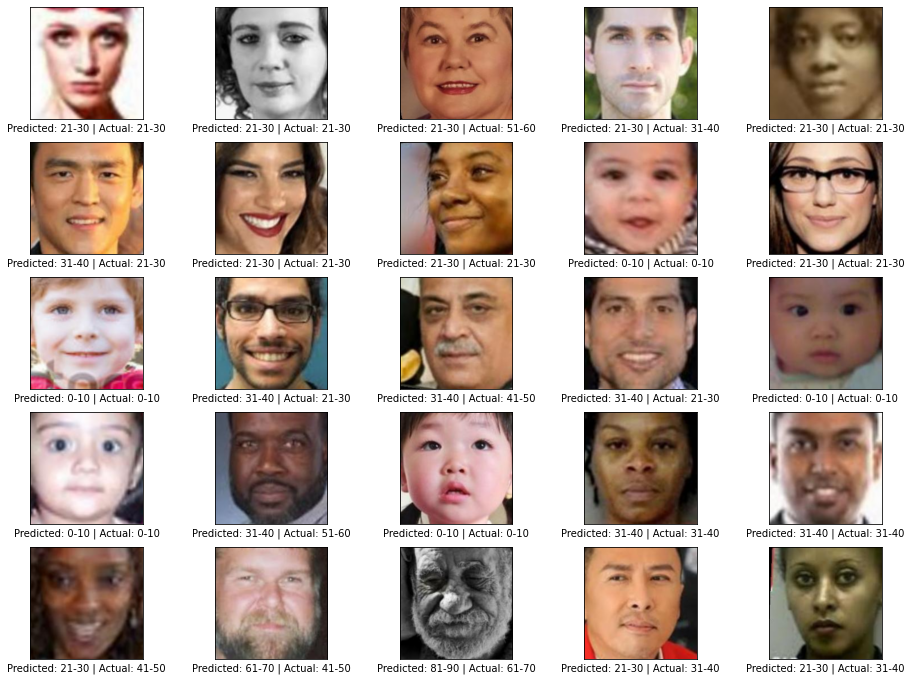

In [62]:
model.eval()

images, labels = next(iter(val_loader))
preds = model(images)
preds = torch.argmax(preds, axis=1)
accuracy = np.array(preds == labels)
print(f"Validation batch accuracy: {np.mean(accuracy)}")

fig, ax = plt.subplots(5, 5, figsize=(16,12))
    
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(invTrans(images[i]).permute(1,2,0))
    plt.xlabel(f"Predicted: {labels_dict[preds[i].item()]} | Actual: {labels_dict[labels[i].item()]}")
plt.show()

## Visualizing activations of each layer

A lot more complicated than I thought. You would have to register PyTorch's hooks on a specific layer to capture input/output of the forward/backward process, but I've never worked with hooks

### ...unless?? another way?

The medium gods have descended https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

In [80]:
model_weights = []
conv_layers = []
model_children = list(model.children()) # list of 14 layers [Conv2d, MaxPool2d, BatchNorm2d..., Flatten, Linear, ReLU]

counter = 0

# append conv layers and weights
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
        
# below code needed if your model has nn.Sequential nested within, but we don't so we don't care
#     elif type(model_children[i]) == nn.Sequential:
#         for j in range(len(model_children[i])):
#             for child in model_children[i][j].children():
#                 if type(child) == nn.Conv2d:
#                     counter+=1
#                     model_weights.append(child.weight)
#                     conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 4
[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), bias=False), Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), bias=False), Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), bias=False), Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1))]


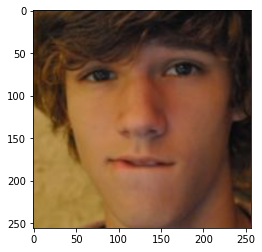

In [118]:
# test image 
image = val_data[245][0]
plt.imshow(np.transpose(invTrans(image), (1,2,0)))

In [119]:
# Generate feature maps. do not run more than once, did not bother figuring out why it breaks
outputs = []
names = []
for layer in conv_layers:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))

for feature_map in outputs:
    print(feature_map.shape)

torch.Size([6, 252, 252])
torch.Size([12, 248, 248])
torch.Size([24, 244, 244])
torch.Size([24, 240, 240])


In [138]:
torch.sum(outputs[3], 0).shape

torch.Size([240, 240])

In [139]:
outputs[3].shape[0]

24

In [134]:
processed = []
for feature_map in outputs:
    # no need to squeeze for ours because none of the feature maps have a dimension = 1 anyway
    # feature_map = feature_map.squeeze(0)
    
    # next we essentially convert from 3D to 2D by taking the mean along the 1st axis
    # (sum then divide by num of channels)
    grey_scale = torch.sum(feature_map, 0)
    grey_scale = grey_scale / feature_map.shape[0]
    processed.append(grey_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(252, 252)
(248, 248)
(244, 244)
(240, 240)


In [142]:
names[i]

'Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1))'

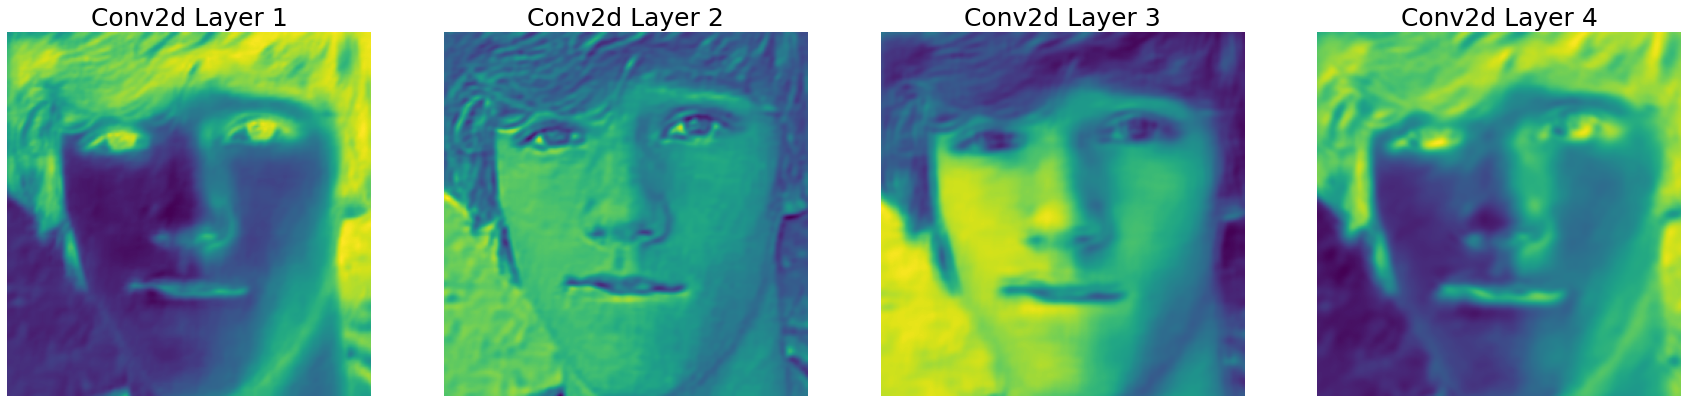

In [147]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    ax = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    ax.axis("off")
    ax.set_title(names[i].split('(')[0] + f" Layer {i+1}", fontsize=25)

# Age distribution

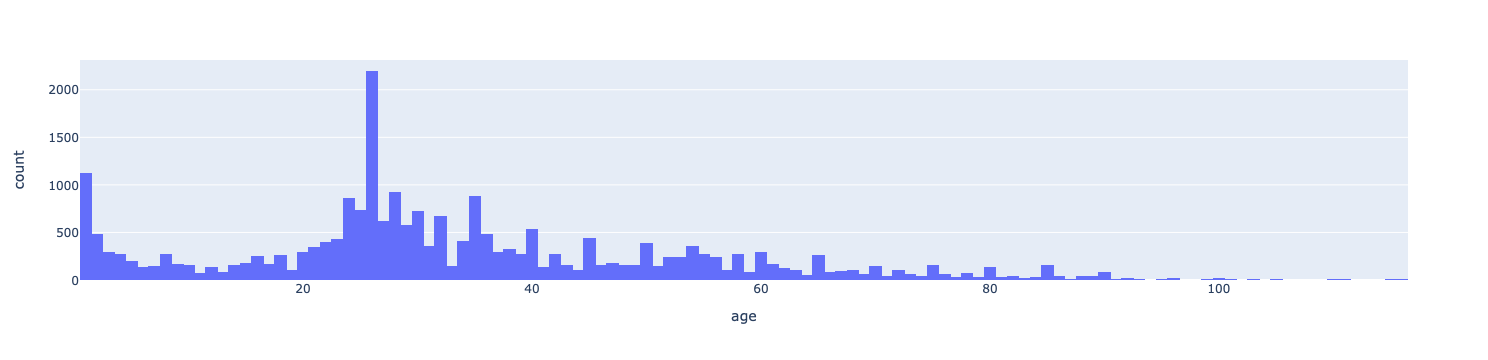

In [27]:
px.histogram(df, x="age")